# Demo with a vlm dataset (openbmb/RLAIF-V-Dataset)

In [1]:
!pip install -q kagglehub

!pip install -q tensorflow
!pip install -q tensorboardX
!pip install -q grain
# !pip install -q git+https://github.com/google/tunix
!pip install -q git+https://github.com/google/qwix

!pip uninstall -q -y flax
!pip install -q git+https://github.com/google/flax.git

!pip install -q huggingface_hub
!pip install -q datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 620.7/620.7 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 158.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 189.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 134.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 22.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 499.4/499.4 kB 23.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.7/69.7 kB 6.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wh

In [2]:
%cd /content
!git clone --branch uiuc-vlm --single-branch https://github.com/PLAN-Lab/tunix.git


/content
Cloning into 'tunix'...
remote: Enumerating objects: 2424, done.
remote: Counting objects: 100% (189/189), done.
remote: Compressing objects: 100% (104/104), done.
remote: Total 2424 (delta 122), reused 91 (delta 85), pack-reused 2235 (from 3)
Receiving objects: 100% (2424/2424), 16.26 MiB | 41.74 MiB/s, done.
Resolving deltas: 100% (1468/1468), done.


In [3]:
%cd /content/tunix
!pip -q install -e .

/content/tunix
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 7.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.2/137.2 MB 18.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.4/55.4 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 8.6 MB/s eta 0:00:00
  Building editable for tunix (pyproject.toml) ... done


In [4]:
# --- autoreload for dev loop ---
import sys, types, importlib
if 'imp' not in sys.modules:
    imp = types.ModuleType('imp')
    imp.reload = importlib.reload
    sys.modules['imp'] = imp

%load_ext autoreload
%autoreload 2

# sanity check import
import tunix
print("tunix imported from:", tunix.__file__)

/usr/local/lib/python3.12/dist-packages/jax/_src/cloud_tpu_init.py:86: UserWarning: Transparent hugepages are not enabled. TPU runtime startup and shutdown time should be significantly improved on TPU v5e and newer. If not already set, you may need to enable transparent hugepages in your VM image (sudo sh -c "echo always > /sys/kernel/mm/transparent_hugepage/enabled")
  warnings.warn(


tunix imported from: /content/tunix/tunix/__init__.py


In [5]:
import functools
import gc
import os
from pprint import pprint
import re
import time

from flax import nnx
import grain
import humanize
import jax
import jax.numpy as jnp
import kagglehub
import optax
from orbax import checkpoint as ocp
import qwix
import tensorflow_datasets as tfds
from tqdm.auto import tqdm

from tunix.examples.data import translation_dataset as data_lib
from tunix.generate import sampler as sampler_lib
from tunix.generate.vlm_sampler import VLMSampler
from tunix.models.gemma3 import params as params_lib
from tunix.models.gemma3 import params_safetensors as params_safetensors_lib

from tunix.sft import metrics_logger
from datasets import load_dataset
from tunix.sft.dpo.dpo_trainer import DpoTrainingConfig
from tunix.sft.dpo.dpo_trainer import DpoTrainer
from tunix.sft.dpo.dpo_trainer import TrainingInput
from huggingface_hub import snapshot_download
from tunix.sft.dpo.dpo_trainer import _generate_ids_and_masks
from tunix.models.gemma3 import model as gemma3_model_lib
from datasets import concatenate_datasets

In [6]:
# ====== Data ======
TRAIN_DATA_DIR = "./data/train"
TEST_DATA_DIR = "./data/test"
TRAIN_FRACTION = 1.0

INTERMEDIATE_CKPT_DIR = "/content/intermediate_ckpt/"
# ====== LoRA ======
RANK = 8
ALPHA = 16.0

# ====== Sharding ======
MESH = [(1, 1), ("fsdp", "tp")]

MAX_PROMPT_LENGTH = 192
TOTAL_GENERATION_STEPS = 192
TEMPERATURE = 0.7
TOP_P = 1.0
TOP_K = 50
BETA = 0.1

# === AdamW, warmup, cosine scheduler ===
LEARNING_RATE = 3e-6
B1 = 0.9
B2 = 0.99
WEIGHT_DECAY = 0.1

# == Cosine decay with warmup scheduler ==
# Linearly increase learning rate from 0. to 5e-6 in the first 10% training
# steps, and then gradually decrease the learning rate to 0 using cosine
# scheduler.
BATCH_SIZE = 4
NUM_BATCHES = 512
NUM_TEST_BATCHES = 100
EVAL_EVERY_N_STEPS = 100

NUM_EPOCHS = 1  # can potentially train for more epochs
TRAIN_FRACTION = 1.0
MAX_STEPS = int(NUM_BATCHES * TRAIN_FRACTION * NUM_EPOCHS)

WARMUP_STEPS = 0.1 * MAX_STEPS
# == Grad clipping ==
# Grad clipping to prevent large gradients. Found this
# important to keep KL divergence in check.
MAX_GRAD_NORM = 0.1

# ====== Inference ======
GENERATION_CONFIGS = {
    # greedy search
    "greedy": {"temperature": 1e-4, "top_k": 1, "top_p": 1.0},
    # some randomness
    "standard": {"temperature": 0.7, "top_k": 50, "top_p": 0.95},
    # liberal
    "liberal": {"temperature": 0.85, "top_k": 2000, "top_p": 1.0},
}

In [ ]:

from huggingface_hub import login, HfApi
import os

HF_TOKEN = "xxx"  # <-- paste your Read token



In [8]:
model_id = "google/gemma-3-1b-it"
ignore_patterns = [
    "*.pth",  # Ignore PyTorch .pth weight files
]
print(f"Downloading {model_id} from Hugging Face...")
local_model_path = snapshot_download(
    repo_id=model_id, ignore_patterns=ignore_patterns, token=HF_TOKEN
)
print(f"Model successfully downloaded to: {local_model_path}")

Fetching 10 files:   0%|          | 0/10 [00:00<?, ?it/s]

config.json:   0%|          | 0.00/899 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/24.3k [00:00<?, ?B/s]

.gitattributes:   0%|          | 0.00/1.68k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/662 [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/35.0 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.00G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/215 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/33.4M [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.69M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.16M [00:00<?, ?B/s]

Model successfully downloaded to: /root/.cache/huggingface/hub/models--google--gemma-3-1b-it/snapshots/dcc83ea841ab6100d6b47a070329e1ba4cf78752


In [9]:
MODEL_CP_PATH = local_model_path

model_config = (
    gemma3_model_lib.Gemma3Config.gemma3_1b()
)  # pick correponding config based on model version
MESH = [(1, 1), ("fsdp", "tp")]
mesh = jax.make_mesh(*MESH)
with mesh:
  gemma3 = params_safetensors_lib.create_model_from_safe_tensors(
      MODEL_CP_PATH, model_config, mesh
  )
  nnx.display(gemma3)

In [10]:
# ==== 3) Load only the tokenizer first (cheap), NOT the whole processor yet ====
from transformers import AutoTokenizer
tok = AutoTokenizer.from_pretrained("google/paligemma-3b-mix-224", token=HF_TOKEN)
print("Tokenizer loaded. pad_id:", tok.pad_token_id, "eos_id:", tok.eos_token_id)

# Adapter that your sampler expects
class HFTokenizerAdapter:
    def __init__(self, hf_tok):
        self.tok = hf_tok
        self._pad_id = self.tok.pad_token_id if self.tok.pad_token_id is not None else self.tok.eos_token_id
        self._eos_id = self.tok.eos_token_id
    def encode(self, s: str):
        return self.tok(s, add_special_tokens=False)["input_ids"]
    def decode(self, ids):
        return self.tok.decode(ids, skip_special_tokens=True)
    def pad_id(self) -> int: return int(self._pad_id)
    def eos_id(self) -> int: return int(self._eos_id)

gemma_tokenizer = HFTokenizerAdapter(tok)
print("Tokenizer adapter ready ✔️")

image_size = 224
print("Processor loaded. image_size:", image_size)

# ==== 5) Construct the sampler LAST (avoid touching model state in __init__) ====
# IMPORTANT: gemma3 must be your PaLI-Gemma nnx Module (not a text-only Gemma).
# If it's named differently, change transformer=... accordingly.
vlm_sampler = VLMSampler(
    transformer=gemma3,
    tokenizer=gemma_tokenizer,
    image_size=image_size,
)
print("VLMSampler ready. pad_id:", vlm_sampler.pad_id(), "eos_id:", vlm_sampler.eos_id())

# --- (Optional) 10-second smoke test with a dummy image ---
import numpy as np, jax.numpy as jnp
dummy = np.zeros((1, image_size, image_size, 3), dtype=np.uint8)
out = vlm_sampler(
    input_strings=["Describe the image:"],
    images=jnp.asarray(dummy),
    max_generation_steps=8,
    temperature=0.0,
    return_logits=False,
    echo=False,
)
print(out.text[0])

/usr/local/lib/python3.12/dist-packages/torch_xla/experimental/gru.py:113: SyntaxWarning: invalid escape sequence '\_'
  * **h_n**: tensor of shape :math:`(D * \text{num\_layers}, H_{out})` or
/usr/local/lib/python3.12/dist-packages/torch_xla/__init__.py:258: UserWarning: `tensorflow` can conflict with `torch-xla`. Prefer `tensorflow-cpu` when using PyTorch/XLA. To silence this warning, `pip uninstall -y tensorflow && pip install tensorflow-cpu`. If you are in a notebook environment such as Colab or Kaggle, restart your notebook runtime afterwards.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/40.0k [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:104: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(


tokenizer.model:   0%|          | 0.00/4.26M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/24.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/607 [00:00<?, ?B/s]

Tokenizer loaded. pad_id: 0 eos_id: 1
Tokenizer adapter ready ✔️
Processor loaded. image_size: 224
VLMSampler ready. pad_id: 0 eos_id: 1
:::DescribeDescribeDescribeDescribeeltas


In [11]:
def get_lora_model(base_model, mesh):
  lora_provider = qwix.LoraProvider(
      module_path=(
          ".*q_einsum|.*kv_einsum|.*gate_proj|.*down_proj|.*up_proj|"
          ".*attn_vec_einsum"
      ),
      rank=RANK,
      alpha=ALPHA,
      #weight_qtype="nf4",
      #tile_size=4,
  )

  model_input = base_model.get_model_input()
  lora_model = qwix.apply_lora_to_model(
      base_model, lora_provider, **model_input
  )

  with mesh:
    state = nnx.state(lora_model)
    pspecs = nnx.get_partition_spec(state)
    sharded_state = jax.lax.with_sharding_constraint(state, pspecs)
    nnx.update(lora_model, sharded_state)

  return lora_model

In [12]:
# Policy model
lora_gemma = get_lora_model(gemma3, mesh=mesh)
nnx.display(lora_gemma)

Output hidden; open in https://colab.research.google.com to view.

In [13]:
from datasets import load_dataset
import numpy as np, jax.numpy as jnp
from PIL import Image
from tunix.models.siglip import preprocess as siglip_pp

# ==== 3) Load only the tokenizer first (cheap), NOT the whole processor yet ====
# Assuming gemma_tokenizer is already defined and is an instance of HFTokenizerAdapter
# If not, you would need to load it here or in a previous cell.
# from transformers import AutoTokenizer
# tok = AutoTokenizer.from_pretrained("google/paligemma-3b-mix-224", token=HF_TOKEN)
# class HFTokenizerAdapter: ... # Define the adapter if not already defined
# gemma_tokenizer = HFTokenizerAdapter(tok)


SPLIT = "train[:5000]"
MAX_PROMPT_LEN = 128
IMAGE_SIZE = 224

ds = load_dataset("openbmb/RLAIF-V-Dataset", split=SPLIT, token=HF_TOKEN)
cols = ["image", "question", "chosen", "rejected"]
ds = ds.remove_columns([c for c in ds.column_names if c not in cols])

def _pick_one_image(img_field):
    """Return a single PIL.Image from the dataset's image field."""
    x = img_field
    if isinstance(x, list):
        if not x:  # empty list, skip later
            return None
        x = x[0]
    if isinstance(x, Image.Image):
        return x.convert("RGB")
    # HF 'Image' feature sometimes gives np.ndarray
    arr = np.array(x)
    if arr.ndim == 3:
        return Image.fromarray(arr).convert("RGB")
    return None

def preprocess_item(ex):
    img = _pick_one_image(ex["image"])
    if img is None:
        return {
            "pixel_values": None,
            "question": ex["question"],
            "chosen": ex["chosen"],
            "rejected": ex["rejected"],
        }
    arr = np.array(img, dtype=np.uint8)[None, ...]              # [1,H,W,3]
    px  = siglip_pp.preprocess(jnp.asarray(arr), IMAGE_SIZE)     # [1,S,S,3] float32
    return {
        "pixel_values": np.asarray(px[0]),                       # [S,S,3]
        "question": ex["question"],
        "chosen": ex["chosen"],
        "rejected": ex["rejected"],
    }

ds = ds.with_transform(preprocess_item)

PROMPT_LEN = 128
ANS_LEN    = 128
PAD = gemma_tokenizer.pad_id()
EOS = gemma_tokenizer.eos_id()

def _left_pad_np(ids, L, pad=PAD):
    # ids: list[int]
    ids = ids[-L:] if len(ids) > L else [pad] * (L - len(ids)) + ids
    return np.asarray(ids, dtype=np.int32)

def _right_pad_np(ids, L, pad=PAD):
    # ids: list[int]
    ids = ids[:L]
    ids = ids + [pad] * (L - len(ids))
    return np.asarray(ids, dtype=np.int32)

def numpy_batches_fixed(dataset, batch_size=1, shuffle=True, seed=0):
    idx = np.arange(len(dataset))
    if shuffle:
        rng = np.random.default_rng(seed); rng.shuffle(idx)
    buf = []
    for i in idx:
        ex = dataset[int(i)]
        if ex["pixel_values"] is None:
            continue
        buf.append(ex)
        if len(buf) == batch_size:
            qs  = [b["question"] for b in buf]
            chs = [b["chosen"]   for b in buf]
            rjs = [b["rejected"] for b in buf]

            q_tok  = [gemma_tokenizer.encode(x) for x in qs]
            ch_tok = [gemma_tokenizer.encode(x) + [EOS] for x in chs]
            rj_tok = [gemma_tokenizer.encode(x) + [EOS] for x in rjs]

            Q  = np.stack([_left_pad_np (ids, PROMPT_LEN) for ids in q_tok ], axis=0)  # [B,P]
            CH = np.stack([_right_pad_np(ids, ANS_LEN   ) for ids in ch_tok], axis=0)  # [B,A]
            RJ = np.stack([_right_pad_np(ids, ANS_LEN   ) for ids in rj_tok], axis=0)  # [B,A]
            PX = np.stack([b["pixel_values"] for b in buf], axis=0).astype(np.float32) # [B,S,S,3]

            # only now move to device
            yield {
                "prompt_ids":   jnp.asarray(Q),
                "chosen_ids":   jnp.asarray(CH),
                "rejected_ids": jnp.asarray(RJ),
                "pixel_values": jnp.asarray(PX),
            }
            buf = []
    if buf:
        qs  = [b["question"] for b in buf]
        chs = [b["chosen"]   for b in buf]
        rjs = [b["rejected"] for b in buf]
        q_tok  = [gemma_tokenizer.encode(x) for x in qs]
        ch_tok = [gemma_tokenizer.encode(x) + [EOS] for x in chs]
        rj_tok = [gemma_tokenizer.encode(x) + [EOS] for x in rjs]
        Q  = np.stack([_left_pad_np (ids, PROMPT_LEN) for ids in q_tok ], axis=0)
        CH = np.stack([_right_pad_np(ids, ANS_LEN   ) for ids in ch_tok], axis=0)
        RJ = np.stack([_right_pad_np(ids, ANS_LEN   ) for ids in rj_tok], axis=0)
        PX = np.stack([b["pixel_values"] for b in buf], axis=0).astype(np.float32)
        yield {
            "prompt_ids":   jnp.asarray(Q),
            "chosen_ids":   jnp.asarray(CH),
            "rejected_ids": jnp.asarray(RJ),
            "pixel_values": jnp.asarray(PX),
        }

# Smoke one batch
b0 = next(numpy_batches_fixed(ds, batch_size=4))
print("Batch pixels:", b0["pixel_values"].shape, "| B:", b0["prompt_ids"].shape[0])
print("Batch prompt_ids:",   b0["prompt_ids"].shape)
print("Batch chosen_ids:",   b0["chosen_ids"].shape)
print("Batch rejected_ids:", b0["rejected_ids"].shape)

README.md: 0.00B [00:00, ?B/s]

RLAIF-V-Dataset_000.parquet:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

RLAIF-V-Dataset_001.parquet:   0%|          | 0.00/1.09G [00:00<?, ?B/s]

RLAIF-V-Dataset_002.parquet:   0%|          | 0.00/970M [00:00<?, ?B/s]

RLAIF-V-Dataset_003.parquet:   0%|          | 0.00/971M [00:00<?, ?B/s]

RLAIF-V-Dataset_004.parquet:   0%|          | 0.00/856M [00:00<?, ?B/s]

RLAIF-V-Dataset_005.parquet:   0%|          | 0.00/755M [00:00<?, ?B/s]

RLAIF-V-Dataset_006.parquet:   0%|          | 0.00/897M [00:00<?, ?B/s]

RLAIF-V-Dataset_007.parquet:   0%|          | 0.00/868M [00:00<?, ?B/s]

RLAIF-V-Dataset_008.parquet:   0%|          | 0.00/1.00G [00:00<?, ?B/s]

RLAIF-V-Dataset_009.parquet:   0%|          | 0.00/828M [00:00<?, ?B/s]

RLAIF-V-Dataset_010.parquet:   0%|          | 0.00/962M [00:00<?, ?B/s]

RLAIF-V-Dataset_011.parquet:   0%|          | 0.00/853M [00:00<?, ?B/s]

RLAIF-V-Dataset_012.parquet:   0%|          | 0.00/826M [00:00<?, ?B/s]

RLAIF-V-Dataset_013.parquet:   0%|          | 0.00/726M [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

Batch pixels: (4, 224, 3) | B: 4
Batch prompt_ids: (4, 128)
Batch chosen_ids: (4, 128)
Batch rejected_ids: (4, 128)


In [14]:
import jax, jax.numpy as jnp

def _make_pos_and_causal_mask(tokens: jnp.ndarray, pad_id: int):
    """
    tokens: [B, L] int32
    returns:
      positions: [B, L] int32
      attn_mask: [B, L, L] bool  (causal & padding-aware)
    """
    # padding mask
    valid = (tokens != pad_id)               # [B, L]
    # positions: 0.. for valid tokens, 0 for pads (as you had)
    positions = (jnp.cumsum(valid.astype(jnp.int32), axis=1) - 1) * valid.astype(jnp.int32)

    # causal lower-triangular (shared across batch)
    L = tokens.shape[1]
    causal = jnp.tril(jnp.ones((L, L), dtype=bool))  # [L, L]

    # combine: query must be valid, key must be valid, and causal
    # broadcasting to [B, L, L]
    attn_mask = (valid[..., None] & valid[:, None, :] & causal[None, ...])
    return positions.astype(jnp.int32), attn_mask

def _vlm_forward_and_cache(policy_mod, *, tokens: jnp.ndarray, pixel_values: jnp.ndarray, pad_id: int):
    tokens = tokens.astype(jnp.int32)
    pixel_values = pixel_values.astype(jnp.float32)

    positions, attn_mask = _make_pos_and_causal_mask(tokens, pad_id)  # <-- causal [B,L,L]
    cache_in = {}  # own the cache per call to avoid side effects

    logits, cache_out = policy_mod(
        last_tokens=tokens,
        positions=positions,
        cache=cache_in,
        attention_mask=attn_mask,     # <-- correct rank-3, causal
        pixel_values=pixel_values,     # ignored for text-only configs
        output_hidden_states=False,
    )
    return logits, cache_out

def _seq_logprob_batch(policy_mod, px, prompt_ids, answer_ids, pad_id):
    """Sum of token logprobs for answer (teacher forcing). Returns [B]."""
    x_ids = jnp.concatenate([prompt_ids, answer_ids[:, :-1]], axis=1)
    logits, _ = _vlm_forward_and_cache(policy_mod, tokens=x_ids, pixel_values=px, pad_id=pad_id)
    La = answer_ids.shape[1]
    ans_logits = logits[:, -La:, :]
    logp = jax.nn.log_softmax(ans_logits, axis=-1)
    tok_logp = jnp.take_along_axis(logp, answer_ids[..., None], axis=-1)[..., 0]
    ans_mask = (answer_ids != pad_id).astype(tok_logp.dtype)
    return (tok_logp * ans_mask).sum(axis=1)  # [B]

def dpo_loss_batch_and_aux(policy, ref, batch, pad_id: int, beta: float = 0.1):
    px = jnp.asarray(batch["pixel_values"], dtype=jnp.float32)
    q  = jnp.asarray(batch.get("prompt_ids",   batch.get("question")),   dtype=jnp.int32)
    ch = jnp.asarray(batch.get("chosen_ids",   batch.get("chosen")),     dtype=jnp.int32)
    rj = jnp.asarray(batch.get("rejected_ids", batch.get("rejected")),   dtype=jnp.int32)

    lp_ch = _seq_logprob_batch(policy, px, q, ch, pad_id)   # [B]
    lp_rj = _seq_logprob_batch(policy, px, q, rj, pad_id)
    lq_ch = _seq_logprob_batch(ref,    px, q, ch, pad_id)
    lq_rj = _seq_logprob_batch(ref,    px, q, rj, pad_id)

    pol_margin = lp_ch - lp_rj                    # [B]
    ref_margin = lq_ch - lq_rj                    # [B]
    advantages = pol_margin - ref_margin          # [B]
    loss = -jax.nn.log_sigmoid(beta * advantages).mean()

    # per-batch metrics
    correct_mask = (pol_margin > 0)               # [B]
    num_correct = correct_mask.sum()
    B = q.shape[0]

    aux = {
        "loss": loss,
        "batch_acc": (num_correct / B),
        "num_correct": num_correct,
        "batch_size": B,
        "policy_margin_mean": pol_margin.mean(),
        "ref_margin_mean": ref_margin.mean(),
        "advantage_mean": advantages.mean(),
    }
    return loss, aux

In [15]:
from flax import nnx
import optax


# immutable templates (never mutated)
policy_template = nnx.clone(lora_gemma)   # trainable LoRA-wrapped model
ref_template    = nnx.clone(gemma3)       # frozen reference

# live states
policy_state = nnx.state(lora_gemma)
ref_state    = nnx.state(gemma3)

PAD_ID = gemma_tokenizer.pad_id()
LR     = 2e-6
BETA   = 0.1
MAX_GRAD_NORM = 0.1

tx = optax.chain(
    optax.clip_by_global_norm(MAX_GRAD_NORM),
    optax.adamw(LR, b1=0.9, b2=0.99, weight_decay=0.1),
)
opt_state = tx.init(policy_state)

def loss_with_state(p_state, batch_arrays):
    pol  = nnx.clone(policy_template); nnx.update(pol, p_state)
    refm = nnx.clone(ref_template);    nnx.update(refm, ref_state)
    loss, aux = dpo_loss_batch_and_aux(pol, refm, batch_arrays, pad_id=PAD_ID, beta=BETA)
    new_p_state = nnx.state(pol)
    return loss, (new_p_state, aux)

@jax.jit
def train_step(policy_state, opt_state, batch_arrays):
    (loss, (policy_state_out, aux)), grads = jax.value_and_grad(
        loss_with_state, has_aux=True
    )(policy_state, batch_arrays)

    updates, opt_state2 = tx.update(grads, opt_state, params=policy_state_out)
    policy_state2 = optax.apply_updates(policy_state_out, updates)
    return loss, policy_state2, opt_state2, aux


step    1/200  loss=0.6523  batch_acc=0.625  cum_acc=0.625  polΔ=+35.000  adv=+1.375  (0.01 steps/s)
step    5/200  loss=0.7188  batch_acc=0.500  cum_acc=0.450  polΔ=-1.312  adv=-0.125  (0.02 steps/s)
step   10/200  loss=0.7383  batch_acc=0.438  cum_acc=0.500  polΔ=-31.875  adv=-0.438  (0.03 steps/s)
step   15/200  loss=0.7656  batch_acc=0.750  cum_acc=0.517  polΔ=+126.000  adv=-0.875  (0.04 steps/s)
step   20/200  loss=0.7930  batch_acc=0.500  cum_acc=0.512  polΔ=+11.750  adv=-1.344  (0.05 steps/s)
step   25/200  loss=0.6289  batch_acc=0.375  cum_acc=0.512  polΔ=+13.125  adv=+2.500  (0.06 steps/s)
step   30/200  loss=0.6289  batch_acc=0.750  cum_acc=0.512  polΔ=+85.500  adv=+2.625  (0.07 steps/s)
step   35/200  loss=0.7305  batch_acc=0.500  cum_acc=0.505  polΔ=+4.781  adv=-0.438  (0.08 steps/s)
step   40/200  loss=0.6758  batch_acc=0.625  cum_acc=0.512  polΔ=+70.500  adv=+1.250  (0.08 steps/s)
step   45/200  loss=0.6836  batch_acc=0.625  cum_acc=0.519  polΔ=+59.250  adv=+0.406  (0.09 

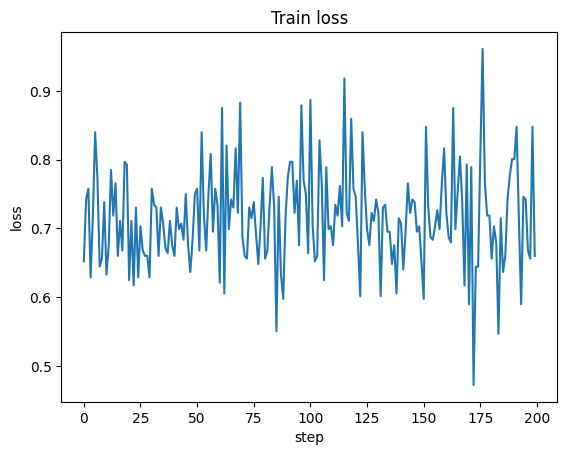

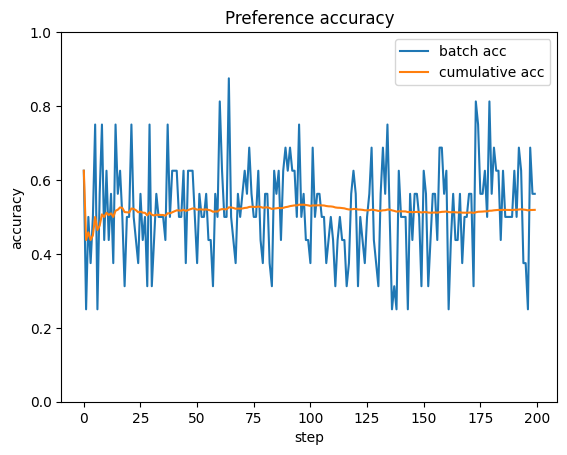

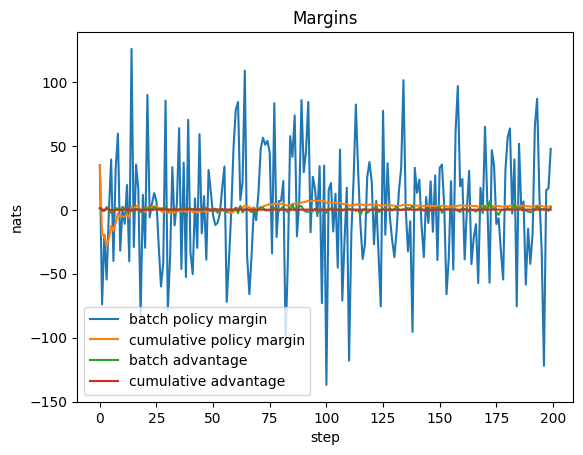

In [16]:
import time, matplotlib.pyplot as plt

steps = 200
log_every = 5


# per-step histories
loss_hist = []
batch_acc_hist = []
polm_hist = []
adv_hist  = []

# cumulative trackers
cum_correct = 0.0
cum_seen    = 0.0
cum_polm_sum = 0.0
cum_adv_sum  = 0.0
cum_acc_hist = []      # for plotting cumulative accuracy
cum_polm_hist = []     # cumulative mean policy margin
cum_adv_hist  = []     # cumulative mean advantage

itr = numpy_batches_fixed(ds, batch_size=16, shuffle=True, seed=42)
t0 = time.time()

for step in range(1, steps + 1):
    batch = next(itr)
    loss, policy_state, opt_state, aux = train_step(policy_state, opt_state, batch)

    # per-step logs
    loss_hist.append(float(loss))
    batch_acc_hist.append(float(aux["batch_acc"]))
    polm_hist.append(float(aux["policy_margin_mean"]))
    adv_hist.append(float(aux["advantage_mean"]))

    # update cumulative stats
    cum_correct += float(aux["num_correct"])
    cum_seen    += float(aux["batch_size"])
    cum_polm_sum += float(aux["policy_margin_mean"]) * float(aux["batch_size"])
    cum_adv_sum  += float(aux["advantage_mean"])     * float(aux["batch_size"])

    cum_acc = cum_correct / max(1.0, cum_seen)
    cum_polm = cum_polm_sum / max(1.0, cum_seen)
    cum_adv  = cum_adv_sum  / max(1.0, cum_seen)

    cum_acc_hist.append(cum_acc)
    cum_polm_hist.append(cum_polm)
    cum_adv_hist.append(cum_adv)

    if step % log_every == 0 or step == 1:
        dt = time.time() - t0
        print(f"step {step:4d}/{steps}  "
              f"loss={loss_hist[-1]:.4f}  "
              f"batch_acc={batch_acc_hist[-1]:.3f}  "
              f"cum_acc={cum_acc:.3f}  "
              f"polΔ={polm_hist[-1]:+.3f}  "
              f"adv={adv_hist[-1]:+.3f}  "
              f"({step/dt:.2f} steps/s)")

# final sync
nnx.update(lora_gemma, policy_state)

# --- plots ---
plt.figure(); plt.plot(loss_hist); plt.title("Train loss"); plt.xlabel("step"); plt.ylabel("loss"); plt.show()

plt.figure(); plt.plot(batch_acc_hist, label="batch acc"); plt.plot(cum_acc_hist, label="cumulative acc")
plt.title("Preference accuracy"); plt.xlabel("step"); plt.ylabel("accuracy"); plt.ylim(0,1); plt.legend(); plt.show()

plt.figure(); plt.plot(polm_hist, label="batch policy margin"); plt.plot(cum_polm_hist, label="cumulative policy margin")
plt.plot(adv_hist, label="batch advantage"); plt.plot(cum_adv_hist, label="cumulative advantage")
plt.title("Margins"); plt.xlabel("step"); plt.ylabel("nats"); plt.legend(); plt.show()